The remap function in OpenCV applies a generic geometrical transformation using a mapping that can be difficult to invert. 
In this example we'll show a solution to the problem of finding an inverse mapping which is based on a very ingenious idea proposed [here](https://stackoverflow.com/a/46009462/1922197).

The mapping used here transforms the image from an equirectangular projection to a rectilinear projection and it is applied using the **Equirec2Perspec** package which can be found [here](https://github.com/fuenwang/Equirec2Perspec). The inverse of this mapping can be calculated analytically but our purpose here is to show a method that can be used for any mapping.

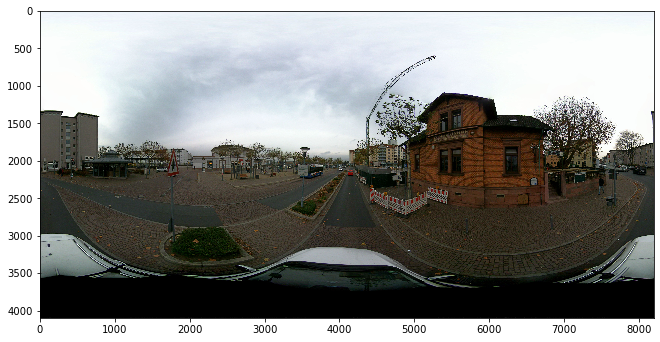

In [225]:
import os
import cv2
import numpy as np
import time
from scipy.spatial import cKDTree

from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(11, 9)

from Equirec2Perspec import Equirec2Perspec as E2P

equirectangular_image = cv2.imread('equirectangular.jpg', cv2.IMREAD_COLOR)

plt.imshow(cv2.cvtColor(equirectangular_image, cv2.COLOR_BGR2RGB))
plt.show()

The **GetPerspective** method was modified to return the mappings that we'll need later on. It just returns the projection plus the maps used as arguments to the remap function.



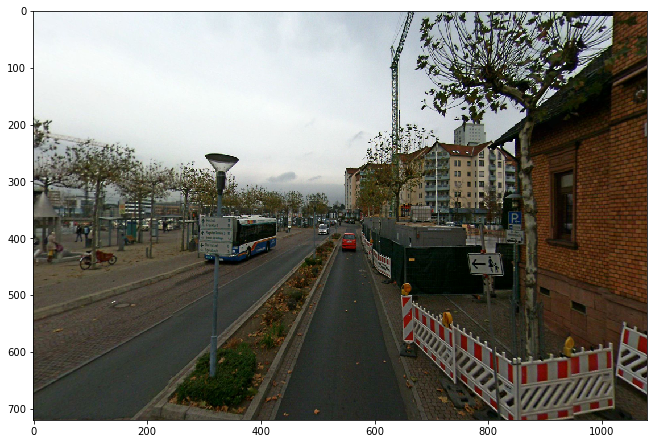

In [224]:
equirectangular = E2P.Equirectangular('equirectangular.jpg')

# parameters of the projection (feel free to play with these!)
FOV = 100
THETA = 0
PHI = 0
height = 720
width = 1080
RADIUS = 128

rectilinear, map1, map2 = equirectangular.GetPerspective(FOV, THETA, PHI, height, width, RADIUS=RADIUS)

plt.imshow(cv2.cvtColor(rectilinear, cv2.COLOR_BGR2RGB))
plt.show()

Now we would like to go back from the rectilinear projection to the equirectangular projection. For this we need to estimate the inverse mapping using the very clever idea mentioned at the beginning.

In [206]:
h, w, _ = rectilinear.shape
map1_inverse = np.zeros((H, W))
map2_inverse = np.zeros((H, W))

s = time.time()

data = []
coords = []
for j in range(w):
    for i in range(h):
        data.append([map1[i, j], map2[i, j]])
        coords.append((i, j))
data = np.array(data)
tree = cKDTree(data, leafsize=16, compact_nodes=True, balanced_tree=True)
coords.append((0, 0))  # extra coords for failed neighbour search

e1 = time.time()
print("Tree creation took {:0.2f} seconds".format(e1-s))

x = np.linspace(0.0, W, num=W, endpoint=False)
y = np.linspace(0.0, H, num=H, endpoint=False)
pts = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
distances, indices = tree.query(pts, k=5, p=2, distance_upper_bound=5.0)

e2 = time.time()
print("Tree query took {:0.2f} seconds".format(e2-e1))

# TODO optimization (any suggestions? :S)
for (x, y), ds, idxs in zip(pts.astype(np.uint16), distances, indices):
    wsum_i = 0
    wsum_j = 0
    wsum = np.finfo(float).eps
    for d, idx in zip(ds, idxs):
        w = 1.0 / (d*d)
        wsum += w
        wsum_i += w*coords[idx][0]
        wsum_j += w*coords[idx][1]
    wsum_i /= wsum
    wsum_j /= wsum
    map1_inverse[y, x] = wsum_j
    map2_inverse[y, x] = wsum_i

e3 = time.time()
print("Weighted sums took {:0.2f} seconds".format(e3-e2))

Tree creation took 17.60 seconds
Tree query took 25.56 seconds
Weighted sums took 537.21 seconds


The last step is to apply the remap function to the rectilinear projection using the inverse maps. The output is cropped for aesthetic reasons.

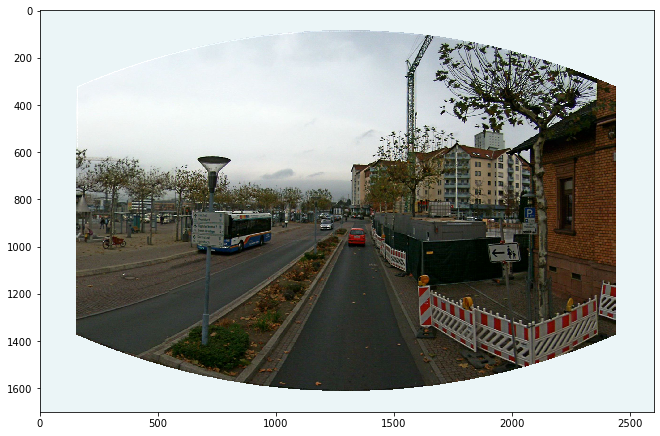

In [226]:
equirectangular_image = cv2.remap(rectilinear, map1_inverse.astype(np.float32), map2_inverse.astype(np.float32), cv2.INTER_CUBIC, borderMode=cv2.BORDER_WRAP)
plt.imshow(cv2.cvtColor(equirectangular_image[1200:2900, 2800:5400], cv2.COLOR_BGR2RGB))
plt.show()

This notebook is available on this [link](https://github.com/twoisprime/twoisprime.github.io/tree/master/notebooks/2020-02-18-remap-inverse.ipynb).